In [7]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import db_dtypes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import make_column_transformer
import warnings
warnings.simplefilter(action='ignore')
from pathlib import Path


In [1]:
from google.cloud import storage

# Verifica que GOOGLE_APPLICATION_CREDENTIALS esté configurado
import os
print(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS'))

# Tu código aquí
client = storage.Client()

/Users/davids./code/davidSA10/gcp/nth-fiber-448914-a7-c1adcd74a08c.json


In [4]:
client = bigquery.Client()

# Create BigQuery Storage client
bqstorage_client = bigquery_storage.BigQueryReadClient()

query = """
 with clean_data as (
        select * EXCEPT (store_number, zip_code, category, vendor_number, county_number),
        CAST(store_number AS NUMERIC) as store_number ,
        CAST(zip_code AS NUMERIC) as zip_code ,
        CAST(category AS NUMERIC) as category,
        CAST(vendor_number AS NUMERIC) as vendor_number
        from `bigquery-public-data.iowa_liquor_sales.sales`
        where date <= '2023-03-31' and date >= '2023-01-01'
        and CAST(vendor_number AS NUMERIC) in (260,421,65,370,85,434,35,301,259,115,395,55,420,205,380,192,297,300,255,389)
        ORDER BY date ASC
    ),
    distinct_vendor as (
        select
            CAST(vendor_number AS NUMERIC) as vendor_number,
            ARRAY_AGG(vendor_name ORDER BY date DESC LIMIT 1) as vendor_name
        from `bigquery-public-data.iowa_liquor_sales.sales`
        group by 1
    ),
    distinct_category as (
        select
            CAST(category AS NUMERIC) as category,
            ARRAY_AGG(category_name ORDER BY date DESC LIMIT 1) as category_name
        from `bigquery-public-data.iowa_liquor_sales.sales`
        group by 1
    ),
    distinct_store as (
        select
            CAST(store_number AS NUMERIC) as store_number,
            ARRAY_AGG(store_name ORDER BY date DESC LIMIT 1) as store_name
        from `bigquery-public-data.iowa_liquor_sales.sales`
        group by 1
    )
    select
        cd.* EXCEPT (vendor_name, category_name, store_name),
        dv.vendor_name,
        dc.category_name,
        ds.store_name
    from clean_data cd
    left join distinct_vendor dv on cd.vendor_number = dv.vendor_number
    left join distinct_category dc on cd.category = dc.category
    left join distinct_store ds on cd.store_number = ds.store_number
"""

# Fetch results using BigQuery Storage API
df = client.query(query).to_dataframe(bqstorage_client=bqstorage_client)

# Display results
df.head()

,invoice_and_item_number,date,address,city,store_location,county,item_number,item_description,pack,bottle_volume_ml,...,sale_dollars,volume_sold_liters,volume_sold_gallons,store_number,zip_code,category,vendor_number,vendor_name,category_name,store_name
0,RINV-04457500342,2023-01-11,1422 FLAMMANG DR,WATERLOO,POINT(-92.32789 42.45998),BLACK HAWK,5036,GLENLIVET 12YR,12,750,...,-167.88,-3.00,-0.79,2538.000000000,50702.000000000,1012300.000000000,370.000000000,[PERNOD RICARD USA],[SINGLE MALT SCOTCH],[HY-VEE FOOD STORE #3 (1866) / WATERLOO]
1,RINV-04554900156,2023-03-16,555 S 51ST ST,WEST DES MOINES,POINT(-93.77293 41.56036),POLK,21538,STAGG BOURBON,6,750,...,-39.00,-0.75,-0.19,2648.000000000,50265.000000000,1011200.000000000,421.000000000,[SAZERAC COMPANY INC],[STRAIGHT BOURBON WHISKIES],[HY-VEE #4 / WDM]
2,INV-55652000072,2023-02-07,901 KELLY ST,CHARLES CITY,POINT(-92.67553 43.06702),FLOYD,11771,BLACK VELVET MINI,8,50,...,12.75,0.05,0.01,2578.000000000,50616.000000000,1012100.000000000,259.000000000,[HEAVEN HILL BRANDS],[CANADIAN WHISKIES],[HY-VEE / CHARLES CITY]
3,INV-56174000007,2023-02-24,505 BOYSON RD NE,CEDAR RAPIDS,POINT(-91.63912 42.04672),LINN,11771,BLACK VELVET MINI,8,50,...,12.75,0.05,0.01,2618.000000000,52402.000000000,1012100.000000000,259.000000000,[HEAVEN HILL BRANDS],[CANADIAN WHISKIES],[HY-VEE DRUGSTORE #6 / CEDAR RAPIDS]
4,INV-56518800030,2023-03-09,4510 MORTENSEN RD,AMES,POINT(-93.67956 42.01212),STORY,11771,BLACK VELVET MINI,8,50,...,13.31,0.05,0.01,4428.000000000,50014.000000000,1012100.000000000,259.000000000,[HEAVEN HILL BRANDS],[CANADIAN WHISKIES],[KUM & GO #200 / AMES]


In [9]:
RAW_DATA_PATH="../../data/raw"

In [ ]:
path_abs = Path(RAW_DATA_PATH).joinpath("data.csv")

In [13]:
path_abs

PosixPath('../../data/raw/data.csv')

In [ ]:
cache_path = /Users/davids./code/hilinski/liquor_demand_forecasting/data/raw

In [15]:
df.to_csv(path_abs, header=True, index=False)

OSError: Cannot save file into a non-existent directory: '../../data/raw'

In [81]:
df.shape

(2468902, 24)

In [82]:
df.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons'],
      dtype='object')

In [83]:
# Counting the percentage of NaN for each column
df.isnull().sum().sort_values(ascending=False) / len(df) #NaN percentage for each column

county_number              1.000000
store_location             0.006283
address                    0.000396
city                       0.000396
zip_code                   0.000396
county                     0.000396
invoice_and_item_number    0.000000
item_description           0.000000
volume_sold_liters         0.000000
sale_dollars               0.000000
bottles_sold               0.000000
state_bottle_retail        0.000000
state_bottle_cost          0.000000
bottle_volume_ml           0.000000
pack                       0.000000
vendor_number              0.000000
item_number                0.000000
vendor_name                0.000000
date                       0.000000
category_name              0.000000
category                   0.000000
store_name                 0.000000
store_number               0.000000
volume_sold_gallons        0.000000
dtype: float64

In [ ]:
df = df.drop('county_number', axis=1)
df = df.dropna(subset=['store_location','address','city','zip_code','county'])

In [85]:
df.shape

(2453391, 23)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2453391 entries, 0 to 2468901
Data columns (total 23 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   invoice_and_item_number  object 
 1   date                     dbdate 
 2   store_number             object 
 3   store_name               object 
 4   address                  object 
 5   city                     object 
 6   zip_code                 object 
 7   store_location           object 
 8   county                   object 
 9   category                 object 
 10  category_name            object 
 11  vendor_number            object 
 12  vendor_name              object 
 13  item_number              object 
 14  item_description         object 
 15  pack                     Int64  
 16  bottle_volume_ml         Int64  
 17  state_bottle_cost        float64
 18  state_bottle_retail      float64
 19  bottles_sold             Int64  
 20  sale_dollars             float64
 21  volume_sold_l

##

## Encoding Categorical values

In [87]:
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['invoice_and_item_number', 'store_number', 'store_name', 'address',
       'city', 'zip_code', 'store_location', 'county', 'category',
       'category_name', 'vendor_number', 'vendor_name', 'item_number',
       'item_description'],
      dtype='object')


In [ ]:
df_object = df.select_dtypes(include=['object'])

In [95]:
df_object.shape

(2453391, 3)

In [ ]:
df_object = df_object[['county', 'category_name','vendor_name']]

In [96]:
df_object.columns

Index(['county', 'category_name', 'vendor_name'], dtype='object')

In [97]:
df_object.shape

(2453391, 3)

In [ ]:
df_object.county.nunique()

99

In [99]:
df_object.category_name.nunique()

43

In [100]:
df_object.vendor_name.nunique()

19

In [ ]:
# Check unique values for column (3)
print(f"The unique values for column country are {df_object.county.unique()}")
print(f"The unique values for column category_name are {df_object.category_name.unique()}")
print(f"The unique values for column vendor_name are {df_object.vendor_name.unique()}")

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output = False)

# Fit encoder
ohe.fit(df_object)

# Display the detected categories
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")

# Display the generated names
print(f"The column names for the encoded values are {ohe.get_feature_names_out()}")

# Transform the columns county, category_name, vendor_name
df_object[ohe.get_feature_names_out()] = ohe.transform(df_object)

# Drop the columns which has been encoded
df_object = df_object.drop(columns = ['county', 'category_name', 'vendor_name'])

# Show the dataset
df_object.head(3)


The unique values for column country are ['DUBUQUE' 'POLK' 'WOODBURY' 'JOHNSON' 'LINN' 'MARION' 'MUSCATINE' 'JONES'
 'STORY' 'HOWARD' 'BOONE' 'FAYETTE' 'BLACK HAWK' 'MARSHALL' 'DALLAS'
 'POTTAWATTAMIE' 'UNION' 'ADAIR' 'WARREN' 'FLOYD' "O'BRIEN" 'CEDAR'
 'MILLS' 'CLINTON' 'DES MOINES' 'SCOTT' 'IOWA' 'DELAWARE' 'WRIGHT'
 'CHICKASAW' 'BENTON' 'WEBSTER' 'LEE' 'CERRO GORDO' 'WASHINGTON' 'KOSSUTH'
 'WAPELLO' 'WINNEBAGO' 'DICKINSON' 'JASPER' 'CARROLL' 'LYON' 'ALLAMAKEE'
 'PAGE' 'BREMER' 'DECATUR' 'MAHASKA' 'MONONA' 'PLYMOUTH' 'BUENA VISTA'
 'PALO ALTO' 'APPANOOSE' 'HUMBOLDT' 'HARRISON' 'SAC' 'ADAMS' 'CLARKE'
 'JEFFERSON' 'POCAHONTAS' 'POWESHIEK' 'VAN BUREN' 'CASS' 'BUTLER' 'CLAY'
 'FREMONT' 'HENRY' 'WINNESHIEK' 'CHEROKEE' 'HAMILTON' 'IDA' 'LUCAS'
 'JACKSON' 'CRAWFORD' 'WAYNE' 'GUTHRIE' 'SHELBY' 'MADISON' 'EMMET' 'SIOUX'
 'TAMA' 'MITCHELL' 'GREENE' 'GRUNDY' 'HARDIN' 'TAYLOR' 'WORTH' 'BUCHANAN'
 'LOUISA' 'OSCEOLA' 'MONTGOMERY' 'CLAYTON' 'MONROE' 'KEOKUK' 'CALHOUN'
 'HANCOCK' 'AUDUBON' 'RINGGOLD

In [ ]:
# Drop the columns which has been encoded
df_object = df_object.drop(columns = ['county', 'category_name', 'vendor_name'])

# Show the dataset
df_object.head(3)

,county_ADAIR,county_ADAMS,county_ALLAMAKEE,county_APPANOOSE,county_AUDUBON,county_BENTON,county_BLACK HAWK,county_BOONE,county_BREMER,county_BUCHANAN,...,vendor_name_LAIRD & COMPANY,vendor_name_LUXCO INC,"vendor_name_MAST-JAGERMEISTER US, INC",vendor_name_MCCORMICK DISTILLING CO.,vendor_name_MOET HENNESSY USA,vendor_name_PERNOD RICARD USA,vendor_name_PHILLIPS BEVERAGE,vendor_name_PROXIMO,vendor_name_REMY COINTREAU USA INC,vendor_name_SAZERAC COMPANY INC
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 

## ENCODING NUMERIC FEATURES

In [105]:
numeric_columns = df.select_dtypes(include=['Int64','float64']).columns
print(numeric_columns)

Index(['pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons'],
      dtype='object')


In [106]:
df_numeric = df.select_dtypes(include=['Int64','float64'])

In [107]:
df_numeric.shape

(2453391, 8)

In [118]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2453391 entries, 0 to 2468901
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   pack                 Int64  
 1   bottle_volume_ml     Int64  
 2   state_bottle_cost    float64
 3   state_bottle_retail  float64
 4   bottles_sold         Int64  
 5   sale_dollars         float64
 6   volume_sold_liters   float64
 7   volume_sold_gallons  float64
dtypes: Int64(3), float64(5)
memory usage: 175.5 MB


In [ ]:
# Counting the number of NaN for each column
df_numeric.isnull().sum().sort_values(ascending=False)

pack                   0
bottle_volume_ml       0
state_bottle_cost      0
state_bottle_retail    0
bottles_sold           0
sale_dollars           0
volume_sold_liters     0
volume_sold_gallons    0
dtype: int64

In [ ]:
df_numeric.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,2453391.0,2453391.0,2.453391e+06,2.453391e+06,2453391.0,2.453391e+06,2.453391e+06,2.453391e+06
mean,12.303005,797.561215,1.254381e+01,1.881364e+01,12.427333,1.705956e+02,9.285979e+00,2.447526e+00
std,8.435902,542.903293,2.090455e+01,3.135385e+01,36.729466,6.397873e+02,4.103982e+01,1.084177e+01
min,1.0,20.0,8.900000e-01,1.340000e+00,-768.0,-8.355840e+03,-1.344000e+03,-3.550400e+02
25%,6.0,375.0,6.000000e+00,9.000000e+00,3.0,4.948000e+01,1.500000e+00,3.900000e-01
50%,12.0,750.0,9.060000e+00,1.359000e+01,6.0,9.168000e+01,4.800000e+00,1.260000e+00
75%,12.0,1000.0,1.500000e+01,2.250000e+01,12.0,1.710000e+02,1.050000e+01,2.770000e+00
max,60.0,5250.0,2.498902e+04,3.748353e+04,13200.0,2.608320e+05,1.320000e+04,3.487070e+03


In [126]:
negative_value = df_numeric[df_numeric['bottles_sold']<0]
print(len(negative_value))

3273


In [136]:
df_numeric[df_numeric['bottles_sold']>=0]

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
1,8,50,8.87,13.31,1,13.31,0.05,0.01
2,12,50,9.90,14.85,1,14.85,0.05,0.01
3,12,50,9.90,14.85,1,14.85,0.05,0.01
4,12,50,8.30,12.45,1,12.45,0.05,0.01
5,10,50,7.92,11.88,1,11.88,0.05,0.01
...,...,...,...,...,...,...,...,...
2468897,1,50,51.60,77.40,1,77.40,0.05,0.01
2468898,1,50,51.60,77.40,2,154.80,0.10,0.02
2468899,1,50,51.60,77.40,2,154.80,0.10,0.02
2468900,1,50,51.60,77.40,4,309.60,0.20,0.05


In [127]:
df_numeric = df_numeric[df_numeric['bottles_sold']>=0]

In [128]:
df_numeric.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,2450118.0,2450118.0,2.450118e+06,2.450118e+06,2450118.0,2.450118e+06,2.450118e+06,2.450118e+06
mean,12.303128,797.566898,1.254163e+01,1.881037e+01,12.458985,1.710364e+02,9.309495e+00,2.453724e+00
std,8.435205,542.926139,2.091086e+01,3.136332e+01,36.732561,6.400021e+02,4.104745e+01,1.084379e+01
min,1.0,20.0,8.900000e-01,1.340000e+00,1.0,1.340000e+00,2.000000e-02,0.000000e+00
25%,6.0,375.0,6.000000e+00,9.000000e+00,3.0,4.950000e+01,1.500000e+00,3.900000e-01
50%,12.0,750.0,9.060000e+00,1.359000e+01,6.0,9.296000e+01,4.800000e+00,1.260000e+00
75%,12.0,1000.0,1.500000e+01,2.250000e+01,12.0,1.710000e+02,1.050000e+01,2.770000e+00
max,60.0,5250.0,2.498902e+04,3.748353e+04,13200.0,2.608320e+05,1.320000e+04,3.487070e+03


In [129]:
df_numeric.shape

(2450118, 8)

In [130]:
2453391-2450118

3273

In [ ]:
print("Min value: ",df_numeric['bottles_sold'].min())
print("Max value: ",df_numeric['bottles_sold'].max())
print("Mean value: ",df_numeric['bottles_sold'].mean())

Min value:  -768
Max value:  13200
Mean value:  12.427333433602715


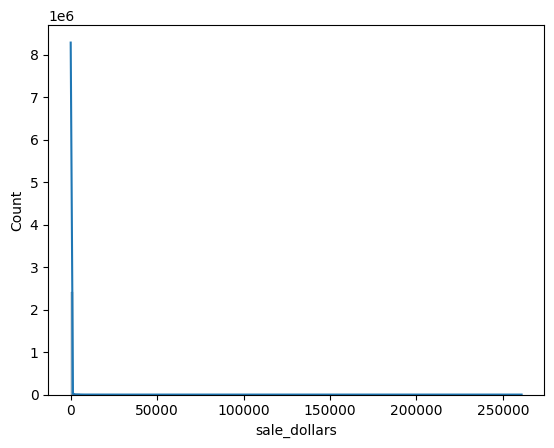

In [131]:
##Para checar su distribución ( histograma )
sns.histplot(df_numeric['sale_dollars'], bins=200,kde = True)
plt.show()

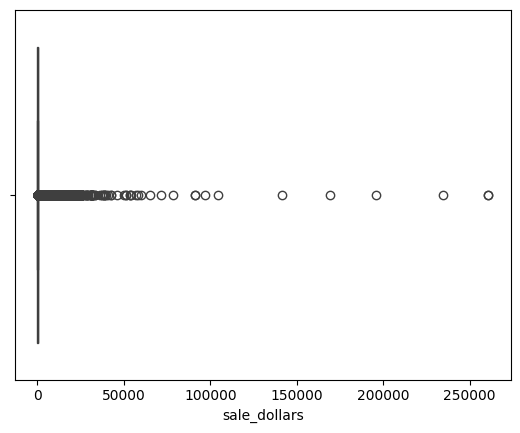

In [132]:
## Datos en gráfica de caja
sns.boxplot(data=df_numeric, x='sale_dollars');

In [133]:
# Initialize the scaler
scaler = RobustScaler()
# Fit and transform the DataFrame
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns, index=df_numeric.index)

In [134]:
df_numeric_scaled

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
1,-0.666667,-1.12,-0.021111,-0.020741,-0.555556,-0.655556,-0.527778,-0.525210
2,0.000000,-1.12,0.093333,0.093333,-0.555556,-0.642881,-0.527778,-0.525210
3,0.000000,-1.12,0.093333,0.093333,-0.555556,-0.642881,-0.527778,-0.525210
4,0.000000,-1.12,-0.084444,-0.084444,-0.555556,-0.662634,-0.527778,-0.525210
5,-0.333333,-1.12,-0.126667,-0.126667,-0.555556,-0.667325,-0.527778,-0.525210
...,...,...,...,...,...,...,...,...
2468897,-1.833333,-1.12,4.726667,4.726667,-0.555556,-0.128066,-0.527778,-0.525210
2468898,-1.833333,-1.12,4.726667,4.726667,-0.444444,0.508971,-0.522222,-0.521008
2468899,-1.833333,-1.12,4.726667,4.726667,-0.444444,0.508971,-0.522222,-0.521008
2468900,-1.833333,-1.12,4.726667,4.726667,-0.222222,1.783045,-0.511111,-0.508403


In [ ]:
### Para una nueva columna o observación, solo transformarla en la escalated de la base
new_wine_scaled = pd.DataFrame(scaler.transform(new_wine), columns=new_wine.columns)
new_wine_scaled